In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf
import tensorflow as tf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
# Usando o Yahoo Finance para baixar os dados históricos do Bitcoin (BTC-USD)
dados = yf.download('BTC-USD', start='2014-01-01', end='2024-11-11')

# Pré-processamento de dados
dados = dados[['Close']]

[*********************100%***********************]  1 of 1 completed


In [3]:
dados

Price,Close
Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2024-11-06,75639.078125
2024-11-07,75904.859375


In [4]:
# Padronização dos dados para melhorar a performance do modelo
scaler = StandardScaler()
dados_scaled = scaler.fit_transform(dados)

In [5]:
# Função para criar os dados de entrada e saída
def create_dataset(data, time_step=300):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Criar os dados de treino e teste
X, y = create_dataset(dados_scaled)

In [6]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# Modelos a serem testados
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=2),
    "SVR": SVR(kernel='linear'),
    "XGBoost": XGBRegressor(),
}

# Loop para treinar e avaliar cada modelo
results = {}
for name, model in models.items():
    # Treinando o modelo
    model.fit(X_train, y_train)
    # Prevendo os preços
    predictions = model.predict(X_test)
    # Calculando as métricas
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {"MAE": mae, "R²": r2}

# Exibindo os resultados
print("Resultados dos Modelos:")
for name, metrics in results.items():
    print(f"{name}: MAE = {metrics['MAE']:.2f}, R² = {metrics['R²']:.2f}")

Resultados dos Modelos:
Linear Regression: MAE = 0.05, R² = 0.99
Ridge Regression: MAE = 0.04, R² = 0.99
Lasso Regression: MAE = 0.23, R² = 0.90
Random Forest: MAE = 0.09, R² = 0.97
Decision Tree: MAE = 0.21, R² = 0.90
KNN Regressor: MAE = 0.90, R² = -0.27
SVR: MAE = 0.06, R² = 0.99
XGBoost: MAE = 0.15, R² = 0.94


In [8]:
# Teste com o modelo SVR e ajuste de parâmetros
model_SVR = SVR(kernel='linear')
model_SVR.fit(X_train, y_train)

# Previsões com o modelo
y_pred_SVR = model_SVR.predict(X_test)

In [9]:
# Teste com o modelo SVR e ajuste de parâmetros
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train, y_train)

# Previsões com o modelo
y_pred_LinearRegression = model_LinearRegression.predict(X_test)

In [10]:
# Teste com o modelo SVR e ajuste de parâmetros
model_Ridge = Ridge()
model_Ridge.fit(X_train, y_train)

# Previsões com o modelo
y_pred_Ridge = model_Ridge.predict(X_test)

In [11]:
# Inverter a padronização dos dados
predicted_price_LinearRegression = scaler.inverse_transform(y_pred_LinearRegression.reshape(-1, 1))
predicted_price_SVR = scaler.inverse_transform(y_pred_SVR.reshape(-1, 1))
predicted_price_Ridge = scaler.inverse_transform(y_pred_Ridge.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

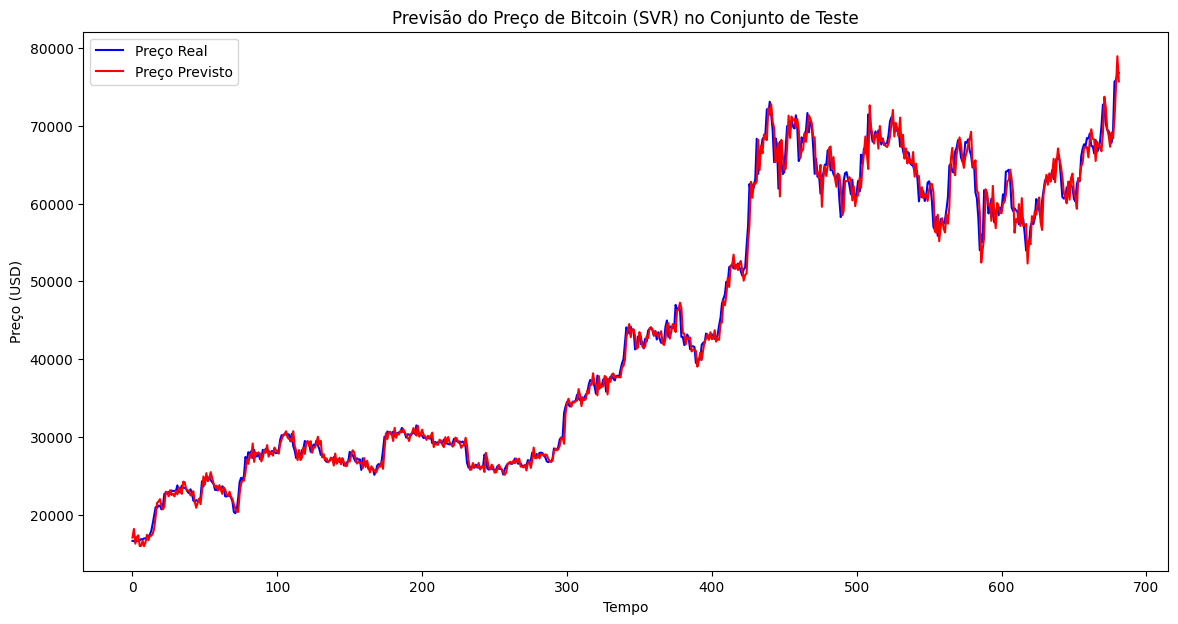

In [12]:
# Visualizar os resultados do conjunto de teste
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(predicted_price_LinearRegression, color='red', label='Preço Previsto')
plt.title('Previsão do Preço de Bitcoin (SVR) no Conjunto de Teste')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

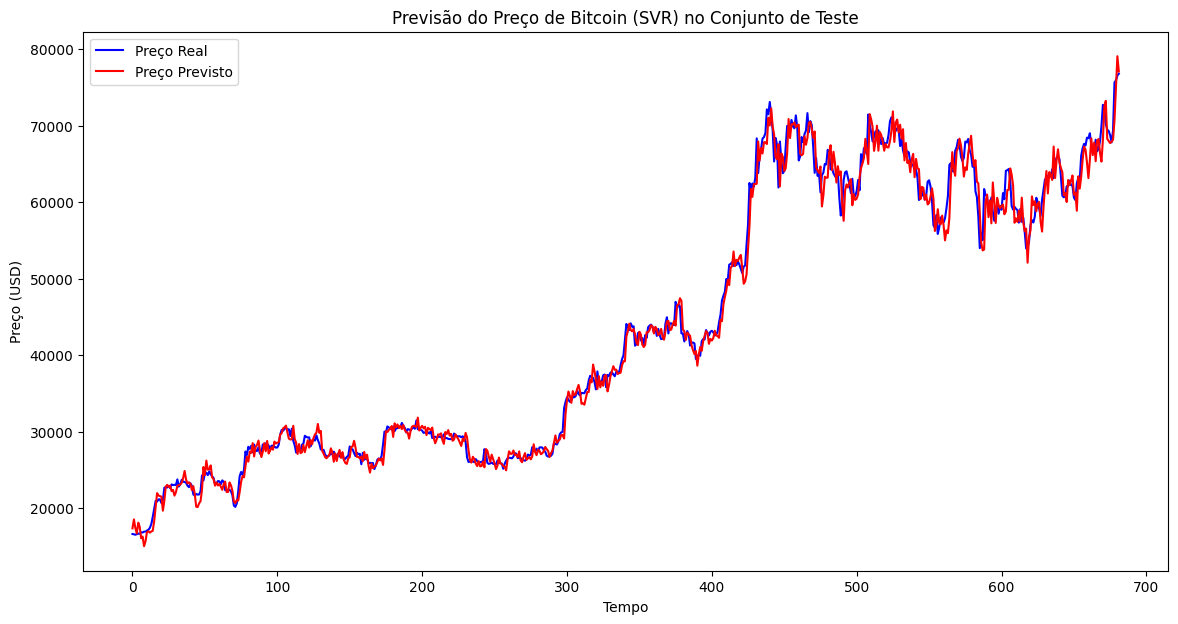

In [13]:
# Visualizar os resultados do conjunto de teste
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(predicted_price_SVR, color='red', label='Preço Previsto')
plt.title('Previsão do Preço de Bitcoin (SVR) no Conjunto de Teste')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

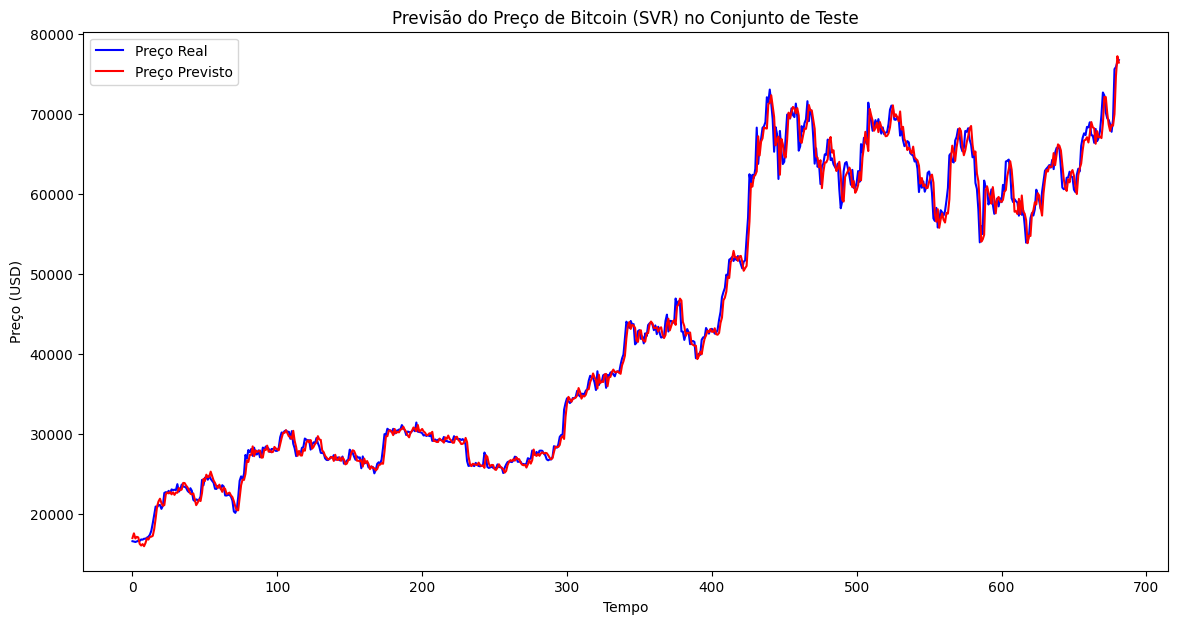

In [14]:
# Visualizar os resultados do conjunto de teste
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Preço Real')
plt.plot(predicted_price_Ridge, color='red', label='Preço Previsto')
plt.title('Previsão do Preço de Bitcoin (SVR) no Conjunto de Teste')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

In [15]:
# Criar o modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(units=1)  # Camada de saída com um único valor (preço do Bitcoin)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Prever e reverter a normalização
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Reverter a normalização dos dados reais
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - loss: 0.1664 - val_loss: 0.0567
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 268ms/step - loss: 0.0105 - val_loss: 0.0419
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - loss: 0.0080 - val_loss: 0.0162
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 268ms/step - loss: 0.0073 - val_loss: 0.0113
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - loss: 0.0062 - val_loss: 0.0170
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - loss: 0.0048 - val_loss: 0.0288
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - loss: 0.0051 - val_loss: 0.0078
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - loss: 0.0042 - val_loss: 0.0101
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 0.0042 - val_loss: 0.0073
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


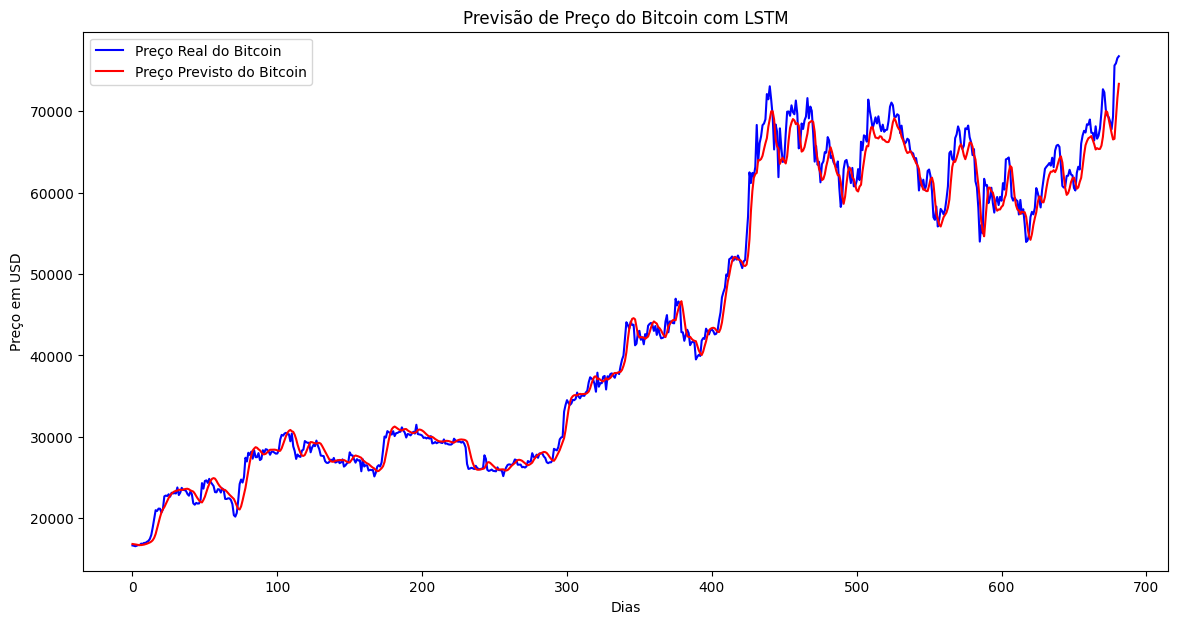

In [16]:

# Visualizar os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Preço Real do Bitcoin')
plt.plot(predictions, color='red', label='Preço Previsto do Bitcoin')
plt.title('Previsão de Preço do Bitcoin com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

In [20]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Configurando os dados de entrada (normalizados, se necessário)
X_train_rnn = np.expand_dims(X_train, axis=2)  # Expande a dimensão para 3D exigido pelas RNNs
X_test_rnn = np.expand_dims(X_test, axis=2)

def build_model(model_type, input_shape):
    model = tf.keras.Sequential()
    if model_type == "Simple RNN":
        model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=input_shape))
    elif model_type == "LSTM":
        model.add(tf.keras.layers.LSTM(32, activation='relu', input_shape=input_shape))
    elif model_type == "GRU":
        model.add(tf.keras.layers.GRU(32, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Dicionário de modelos
models = {
    "Simple RNN": build_model("Simple RNN", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    "LSTM": build_model("LSTM", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    "GRU": build_model("GRU", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
}

# Avaliando os modelos
results_rnn = {}
for name, model in models.items():
    print(f"Avaliando o modelo: {name}")
    model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.2)
    predictions = model.predict(X_test_rnn).flatten()
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results_rnn[name] = {"MAE": mae, "R²": r2}

# Exibindo os resultados
print("\nResultados dos Modelos RNN:")
for name, metrics in results_rnn.items():
    print(f"{name}: MAE = {metrics['MAE']:.2f}, R² = {metrics['R²']:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Avaliando o modelo: Simple RNN
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Avaliando o modelo: LSTM
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Avaliando o modelo: GRU
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Resultados dos Modelos RNN:
Simple RNN: MAE = 0.05, R² = 0.99
LSTM: MAE = 0.10, R² = 0.98
GRU: MAE = 0.05, R² = 0.99
